In [1]:
# -----------------------------
# 🧩 STEP 1: Load the pickled generation files
# -----------------------------
import pickle

with open("train_generations.pkl", "rb") as f:
    train_data = pickle.load(f)

with open("validation_generations.pkl", "rb") as f:
    val_data = pickle.load(f)

print("✅ Loaded train/val data.")
print(f"Train examples: {len(train_data)}")
print(f"Val examples: {len(val_data)}")

✅ Loaded train/val data.
Train examples: 25
Val examples: 25


In [2]:
# -----------------------------
# 🔍 STEP 2: Extract responses and entropy values
# -----------------------------
import torch

def extract_embeddings_and_entropy(data_dict):
    embeddings = []
    entropies = []

    for item in data_dict.values():
        for _, _, embedding in item["responses"]:
            if isinstance(embedding, torch.Tensor):
                embeddings.append(embedding.squeeze())  # remove extra batch dim if needed
                entropies.append(item["entropy"])

    return torch.stack(embeddings), torch.tensor(entropies)



train_embs, train_entropies = extract_embeddings_and_entropy(train_data)
val_embs, val_entropies = extract_embeddings_and_entropy(val_data)

print("Train emb shape:", train_embs.shape)
print("Val emb shape:", val_embs.shape)

Train emb shape: torch.Size([250, 2048])
Val emb shape: torch.Size([250, 2048])


In [3]:
import numpy as np

# Convert to numpy arrays
ent_train = train_entropies.numpy()
ent_val = val_entropies.numpy()

# Define high/low thresholds using percentiles
low_thresh = np.percentile(ent_train, 33)
high_thresh = np.percentile(ent_train, 66)

def label_entropy(ent, low, high):
    if ent <= low:
        return 0  # low entropy
    elif ent >= high:
        return 1  # high entropy
    else:
        return -1  # ambiguous

# Label training data
y_train = np.array([label_entropy(e, low_thresh, high_thresh) for e in ent_train])
y_val = np.array([label_entropy(e, low_thresh, high_thresh) for e in ent_val])

# Filter out ambiguous (middle 1/3)
train_mask = y_train != -1
val_mask = y_val != -1

X_train = train_embs[train_mask].to(torch.float32).numpy()
X_val = val_embs[val_mask].to(torch.float32).numpy()

y_train = y_train[train_mask]
y_val = y_val[val_mask]

print(f"Final train size: {len(y_train)}, class balance: {np.mean(y_train):.2f}")


Final train size: 180, class balance: 0.50


In [5]:
from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression
# -----------------------------
# 2. Label using entropy percentiles
# -----------------------------
def label_entropy(entropies, low_thresh, high_thresh):
    labels = []
    for ent in entropies:
        if ent <= low_thresh:
            labels.append(0)
        elif ent >= high_thresh:
            labels.append(1)
        else:
            labels.append(-1)  # ambiguous
    return np.array(labels)

# Convert entropy tensors to NumPy
ent_train = train_entropies.numpy()
ent_val = val_entropies.numpy()

# Use percentiles to define clearer label boundaries
low_thresh = np.percentile(ent_train, 33)
high_thresh = np.percentile(ent_train, 66)

y_train_full = label_entropy(ent_train, low_thresh, high_thresh)
y_val_full = label_entropy(ent_val, low_thresh, high_thresh)

# -----------------------------
# 3. Filter out ambiguous examples (label == -1)
# -----------------------------
train_mask = y_train_full != -1
val_mask = y_val_full != -1

X_train = train_embs[train_mask].float().numpy()
X_val = val_embs[val_mask].float().numpy()
y_train = y_train_full[train_mask]
y_val = y_val_full[val_mask]

print(f"✅ Final train size: {len(y_train)}, class balance: {np.mean(y_train):.2f}")
print(f"✅ Final val size: {len(y_val)}, class balance: {np.mean(y_val):.2f}")

probe = LogisticRegression(max_iter=5000)
probe.fit(X_train, y_train)

# Predict
val_probs = probe.predict_proba(X_val)[:, 1]
val_preds = (val_probs > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_val, val_preds)
auc = roc_auc_score(y_val, val_probs)

print(f"✅ Validation Accuracy: {acc:.4f}")
print(f"✅ Validation AUROC:   {auc:.4f}")

✅ Final train size: 180, class balance: 0.50
✅ Final val size: 190, class balance: 0.42
✅ Validation Accuracy: 0.5789
✅ Validation AUROC:   0.5516


In [6]:
# -----------------------------
# 2. Label using entropy percentiles
# -----------------------------
def label_entropy(entropies, low_thresh, high_thresh):
    labels = []
    for ent in entropies:
        if ent <= low_thresh:
            labels.append(0)
        elif ent >= high_thresh:
            labels.append(1)
        else:
            labels.append(-1)  # ambiguous
    return np.array(labels)

# Convert entropy tensors to NumPy
ent_train = train_entropies.numpy()
ent_val = val_entropies.numpy()

# Use percentiles to define clearer label boundaries
low_thresh = np.percentile(ent_train, 33)
high_thresh = np.percentile(ent_train, 66)

y_train_full = label_entropy(ent_train, low_thresh, high_thresh)
y_val_full = label_entropy(ent_val, low_thresh, high_thresh)

# -----------------------------
# 3. Filter out ambiguous examples (label == -1)
# -----------------------------
train_mask = y_train_full != -1
val_mask = y_val_full != -1

X_train = train_embs[train_mask].float().numpy()
X_val = val_embs[val_mask].float().numpy()
y_train = y_train_full[train_mask]
y_val = y_val_full[val_mask]

print(f"✅ Final train size: {len(y_train)}, class balance: {np.mean(y_train):.2f}")
print(f"✅ Final val size: {len(y_val)}, class balance: {np.mean(y_val):.2f}")

probe = LogisticRegression(max_iter=5000)
probe.fit(X_train, y_train)

# Predict
val_probs = probe.predict_proba(X_val)[:, 1]
val_preds = (val_probs > 0.5).astype(int)

# Metrics
acc = accuracy_score(y_val, val_preds)
auc = roc_auc_score(y_val, val_probs)

print(f"✅ Validation Accuracy: {acc:.4f}")
print(f"✅ Validation AUROC:   {auc:.4f}")

✅ Final train size: 180, class balance: 0.50
✅ Final val size: 190, class balance: 0.42
✅ Validation Accuracy: 0.5789
✅ Validation AUROC:   0.5516


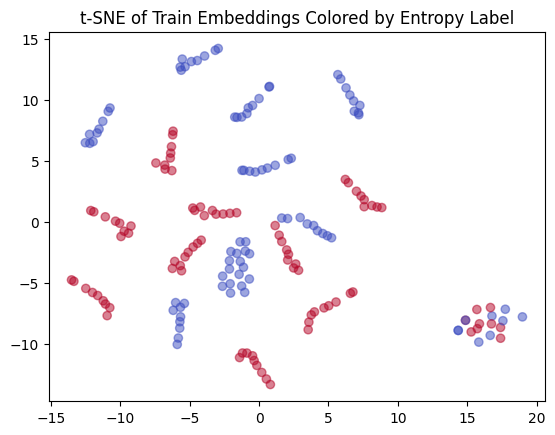

In [7]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

X_embedded = TSNE(n_components=2).fit_transform(X_train)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap='coolwarm', alpha=0.5)
plt.title("t-SNE of Train Embeddings Colored by Entropy Label")
plt.show()

Metrics / Plots from the training

c:\Users\Anna\miniconda3\envs\ml-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


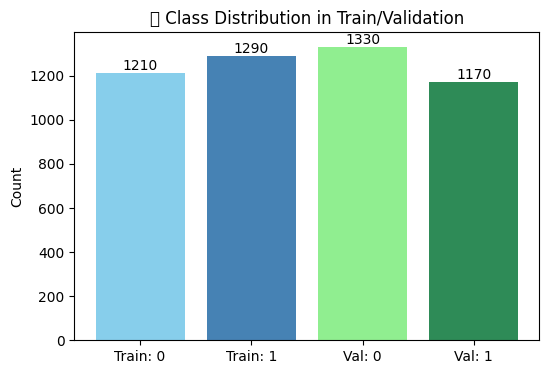

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_label_distribution(y_train, y_val):
    plt.figure(figsize=(6, 4))
    bars = plt.bar(["Train: 0", "Train: 1", "Val: 0", "Val: 1"],
                   [np.sum(y_train==0), np.sum(y_train==1), np.sum(y_val==0), np.sum(y_val==1)],
                   color=["skyblue", "steelblue", "lightgreen", "seagreen"])
    plt.title("🔍 Class Distribution in Train/Validation")
    plt.ylabel("Count")
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 1, int(yval), ha="center", va="bottom", fontsize=10)
    plt.show()

plot_label_distribution(y_train, y_val)

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


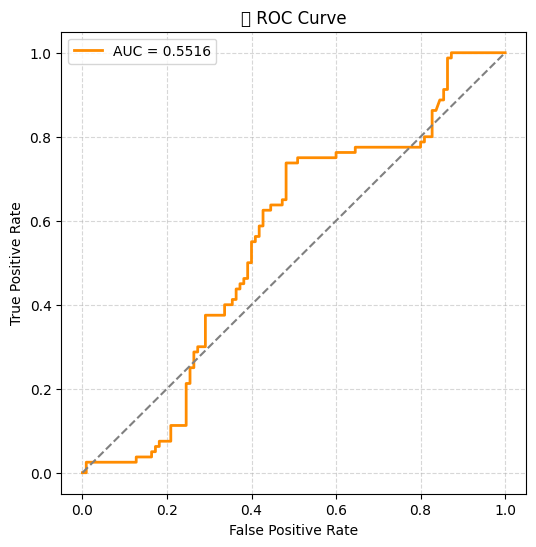

In [8]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(y_true, y_probs, title="ROC Curve"):
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    auc_score = auc(fpr, tpr)

    plt.figure(figsize=(6, 6))
    plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color="darkorange", linewidth=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.title(f"📉 {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

plot_roc_curve(y_val, val_probs)


c:\Users\Anna\miniconda3\envs\ml-env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


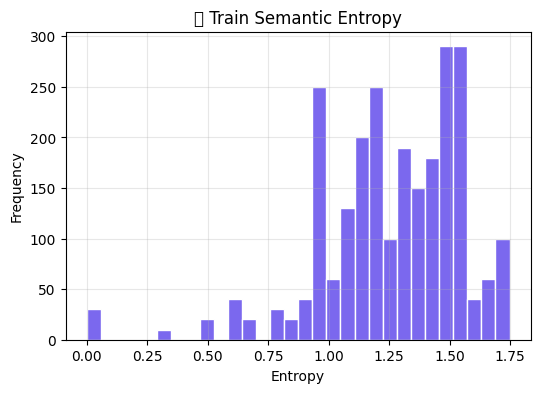

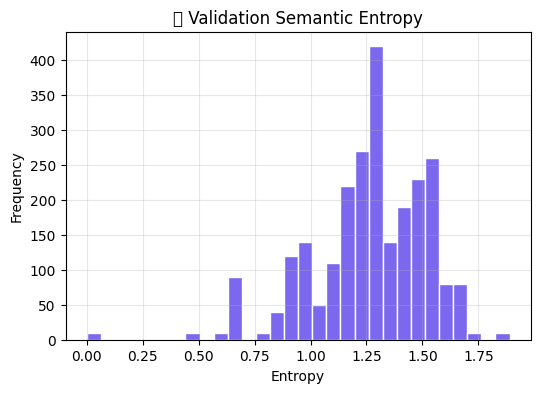

In [13]:
def plot_entropy_distribution(entropies, title="Entropy Distribution"):
    plt.figure(figsize=(6, 4))
    plt.hist(entropies, bins=30, color="mediumslateblue", edgecolor="white")
    plt.title(f"📊 {title}")
    plt.xlabel("Entropy")
    plt.ylabel("Frequency")
    plt.grid(alpha=0.3)
    plt.show()

plot_entropy_distribution(train_entropies, "Train Semantic Entropy")
plot_entropy_distribution(val_entropies, "Validation Semantic Entropy")